<a href="https://colab.research.google.com/github/ElatmaniOumaima/MachineLearning/blob/main/methodes_de_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle


# Adaptive Thresholding:
the tresholding principe ⁉
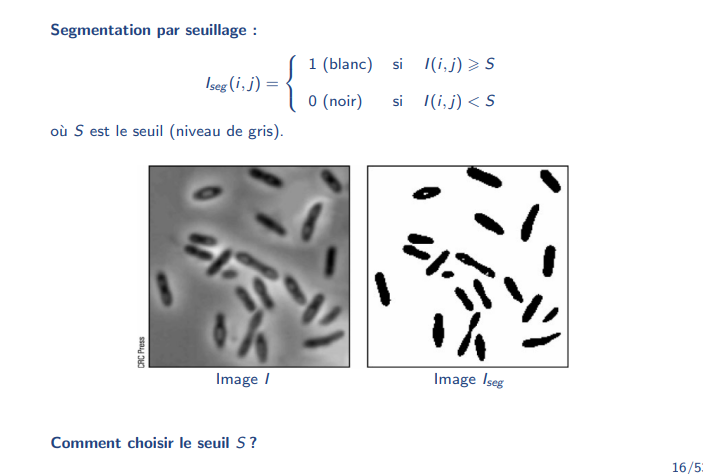

##what is the adaptive tresholding:
Adaptive thresholding is a form of image thresholding technique in which rather than specifying the threshold value manually or using any restrictions, the threshold value is adjusted and selected automatically according to the image pixels and layout for converting the image pixels to grayscale or a binary image. Essentially, this method supports the automatic selection of the threshold value for segregating the main object from its background in conditions where there are different lighting conditions, colors or contrast in the image.

Threshold value for an image is the intensity of the pixel at which the pixels corresponding to foreground and background are separated. This means that image pixels with higher intensities than the threshold value will be separated from the image pixels with lower intensities than the threshold value. If we implement adaptive thresholding then, instead of manually providing a single value of the threshold through basic effort, we will be able to differentiate the foreground and background of the image more efficiently using a much more accurate threshold value.

##How it works :
The objective of using adaptive thresholding is to statistically examine the local regions of the image and find an optimal value of threshold for each region through which we can easily separate the image regions. We can use either arithmetic or gaussian mean of the pixel intensities in each region to compute the threshold value T for each region.

When considering arithmetic mean, each pixel in the neighborhood has equal contribution towards the threshold value and in the gaussian mean, image pixel values which are farther away from the (x, y)-coordinate center of the region make less contribution to the overall calculation of T.

Therefore, the general formula for computing T is -

T = mean(IL) - C

Where, the mean is either arithmetic or gaussian, IL is the local sub-region of the image I and C is some constant which we can use to fine tune the threshold value T.

##Steps followed by THe adaptive tresholding:
Seuillage automatique
Algorithme :
1. Calcul de l’histogramme de l’image.
2. S´electionner un seuil initial T0.
3. Calculer des intensit´es moyennes m1 et m2 des groupes G1 et G2.
4. Calcul du nouveau seuil T = (m1 + m2)/2.
5. on repete le processus jusqu'a que le seuil soint inchangeable Ti=Ti-1

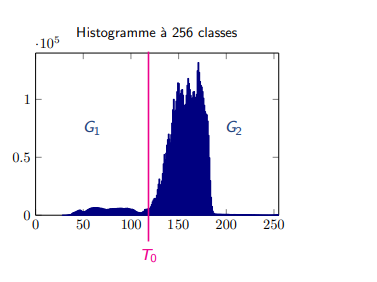


L'image seuillée adaptative a été sauvegardée : /content/treshold/otsu_thresholding/adaptive_threshold_text.png


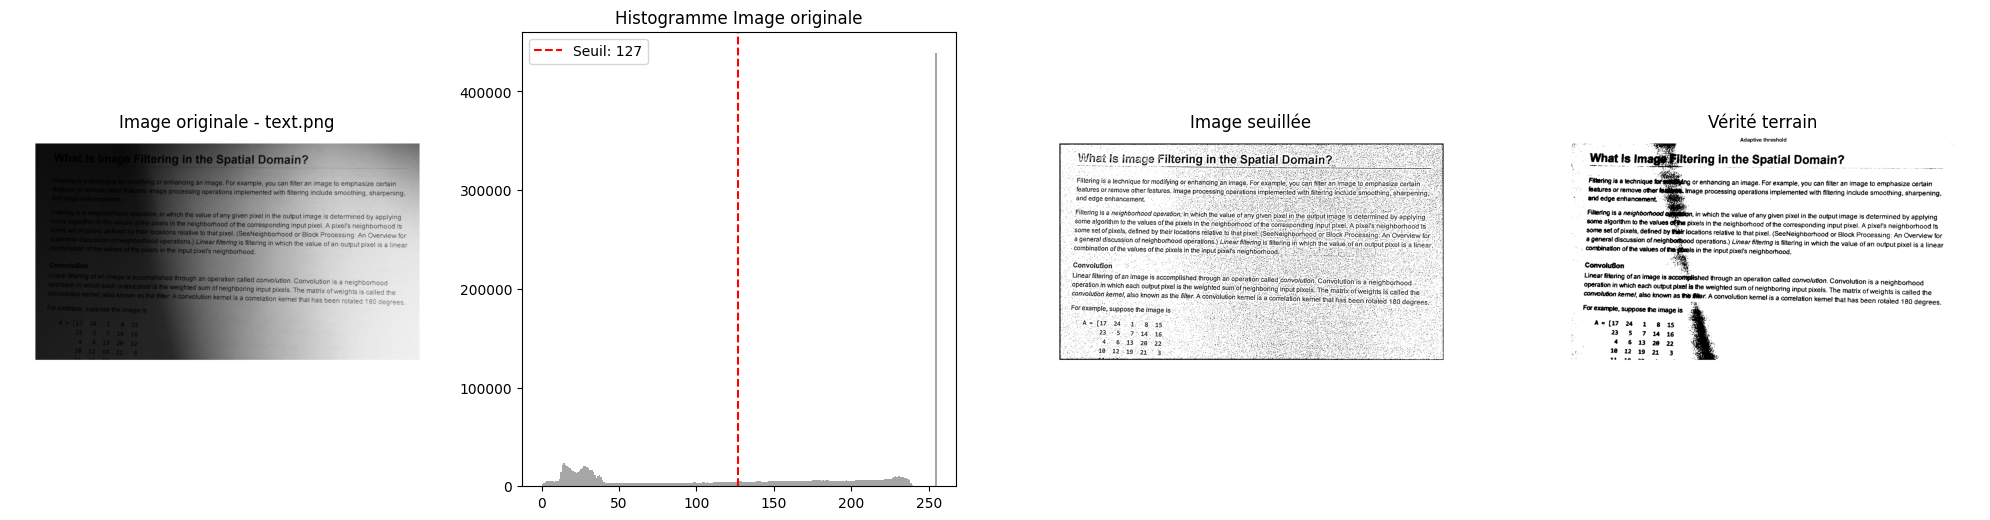

Métriques pour text.png:
  Coefficient de Dice : 0.9507
  Indice de Jaccard (IoU) : 0.9061
  Sensibilité : 0.9425
  Spécificité : 0.6223



In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

# Dossiers des images et des masques de vérité terrain
image_folder = '/content/treshold/adaptive tresholding'
ground_truth_folder = '/content/treshold/trueadaptive'

# Dossier pour sauvegarder les images seuillées après Otsu
output_folder = '/content/treshold/otsu_thresholding'

# Vérifier si le dossier existe, sinon le créer
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Lister et trier les fichiers d'image et de masques
image_files = sorted([f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
ground_truth_files = sorted([f for f in os.listdir(ground_truth_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Vérifier la correspondance entre les deux listes
if len(image_files) != len(ground_truth_files):
    print("Erreur : Les dossiers contiennent un nombre différent de fichiers.")
    exit()

# Fonction pour calculer les métriques
def calculate_metrics(predicted, ground_truth):
    """Calculer le Dice coefficient, Jaccard index, sensibilité, et spécificité."""
    intersection = np.sum(predicted & ground_truth)
    union = np.sum(predicted | ground_truth)

    dice_coefficient = (2 * intersection) / (np.sum(predicted) + np.sum(ground_truth)) if (np.sum(predicted) + np.sum(ground_truth)) > 0 else 0
    jaccard_index = intersection / union if union > 0 else 0
    sensitivity = intersection / np.sum(ground_truth) if np.sum(ground_truth) > 0 else 0
    specificity = np.sum((predicted == 0) & (ground_truth == 0)) / np.sum(ground_truth == 0) if np.sum(ground_truth == 0) > 0 else 0

    return dice_coefficient, jaccard_index, sensitivity, specificity

# Initialiser une liste pour stocker les métriques
metrics = []

# Traiter chaque paire image/masque
for image_file, ground_truth_file in zip(image_files, ground_truth_files):
    # Chemins des fichiers image et masque
    image_path = os.path.join(image_folder, image_file)
    ground_truth_path = os.path.join(ground_truth_folder, ground_truth_file)

    # Charger l'image et le masque de vérité terrain
    image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)

    # Vérifier que les fichiers ont été chargés correctement
    if image_gray is None or ground_truth is None:
        print(f"Erreur lors du chargement de {image_file} ou {ground_truth_file}.")
        continue

    # Appliquer le seuillage adaptatif uniquement sur l'image
    adaptive_thresholded_image = cv2.adaptiveThreshold(
        image_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )

    # Sauvegarder l'image après seuillage adaptatif
    output_image_path = os.path.join(output_folder, f"adaptive_threshold_{image_file}")
    cv2.imwrite(output_image_path, adaptive_thresholded_image)
    print(f"L'image seuillée adaptative a été sauvegardée : {output_image_path}")

    # Convertir les images en format binaire
    ground_truth_binary = (ground_truth > 127).astype(np.uint8)  # Seuil à 127 pour binariser
    predicted_binary = (adaptive_thresholded_image > 0).astype(np.uint8)

    # Calculer les métriques
    dice, jaccard, sensitivity, specificity = calculate_metrics(predicted_binary, ground_truth_binary)

    # Stocker les métriques
    metrics.append({
        'image': image_file,
        'dice_coefficient': dice,
        'jaccard_index': jaccard,
        'sensitivity': sensitivity,
        'specificity': specificity
    })

    # Visualiser les résultats
    plt.figure(figsize=(20, 10))

    # Image originale en niveaux de gris
    plt.subplot(2, 4, 1)
    plt.imshow(image_gray, cmap='gray')
    plt.title(f"Image originale - {image_file}")
    plt.axis('off')

    # Histogramme de l'image originale
    plt.subplot(2, 4, 2)
    plt.hist(image_gray.ravel(), bins=256, range=(0, 255), color='gray', alpha=0.7)

    # Ajouter un marqueur pour le seuil sur l'histogramme
    threshold_value = 127  # Définir ici le seuil
    plt.axvline(x=threshold_value, color='red', linestyle='--', label=f"Seuil: {threshold_value}")

    plt.title("Histogramme Image originale")
    plt.legend()

    # Image après seuillage adaptatif
    plt.subplot(2, 4, 3)
    plt.imshow(adaptive_thresholded_image, cmap='gray')
    plt.title("Image seuillée")
    plt.axis('off')

    # Masque de vérité terrain
    plt.subplot(2, 4, 4)
    plt.imshow(ground_truth_binary, cmap='gray')
    plt.title("Vérité terrain")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Afficher les métriques pour toutes les images
for metric in metrics:
    print(f"Métriques pour {metric['image']}:")
    print(f"  Coefficient de Dice : {metric['dice_coefficient']:.4f}")
    print(f"  Indice de Jaccard (IoU) : {metric['jaccard_index']:.4f}")
    print(f"  Sensibilité : {metric['sensitivity']:.4f}")
    print(f"  Spécificité : {metric['specificity']:.4f}\n")


1. Coefficient de Dice (0.9507)
Définition : Le coefficient de Dice mesure la similarité entre la segmentation prédite et la vérité terrain. Sa valeur est comprise entre 0 et 1, où 1 représente une correspondance parfaite.
Interprétation : Une valeur de 0.9507 indique une correspondance très élevée entre la segmentation réalisée et la vérité terrain. Cela signifie que la méthode de seuillage a bien segmenté l'image.
2. Indice de Jaccard (IoU, 0.9061)
Définition : L'IoU mesure l'intersection sur l'union des pixels segmentés et ceux de la vérité terrain. C'est une autre mesure de la qualité de la segmentation, souvent utilisée dans les tâches de vision par ordinateur.
Interprétation : Une valeur de 0.9061 indique que plus de 90% des pixels prévus comme segmentés sont en accord avec la vérité terrain. Cela confirme une segmentation globalement correcte, avec quelques pixels mal classifiés.
3. Sensibilité (0.9425)
Définition : La sensibilité (ou rappel) mesure la capacité du modèle à détecter les pixels positifs (c'est-à-dire les pixels segmentés correctement).
Interprétation : Une valeur de 0.9425 signifie que 94.25% des pixels positifs (vérité terrain) ont été correctement identifiés par le modèle. C'est une très bonne performance pour cette métrique.
4. Spécificité (0.6223)
Définition : La spécificité mesure la capacité à identifier correctement les pixels négatifs (non segmentés dans la vérité terrain).
Interprétation : Une valeur de 0.6223 indique que 62.23% des pixels négatifs ont été correctement identifiés. Ce score est plus faible par rapport aux autres métriques, ce qui signifie que le modèle a tendance à inclure des faux positifs (des pixels segmentés alors qu'ils ne devraient pas l'être).
Analyse globale
Points forts :

Les métriques de Dice, IoU, et Sensibilité montrent que le modèle est très performant pour détecter les régions d'intérêt (pixels positifs).
Cela indique que le seuillage adaptatif est efficace pour cette tâche.
Limite :

La spécificité plus faible signale une difficulté à rejeter les régions non pertinentes (faux positifs). Cela pourrait être dû à un bruit dans l'image ou à une sensibilité trop élevée du seuil.


# methode Otsu
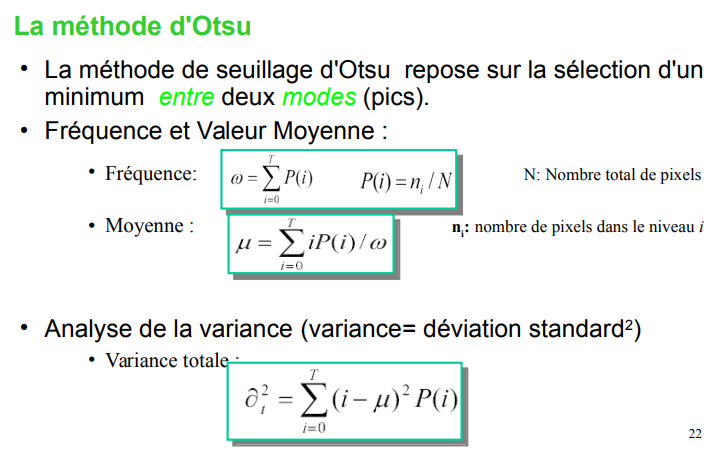
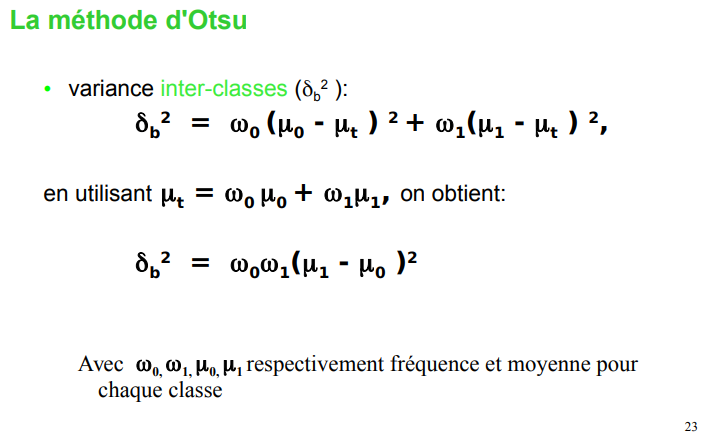
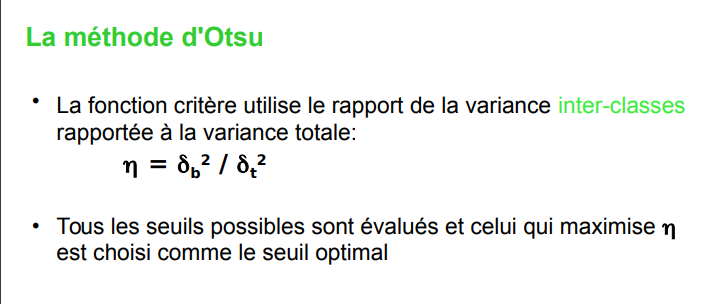

Erreur lors du chargement de brain.png ou brain.png.


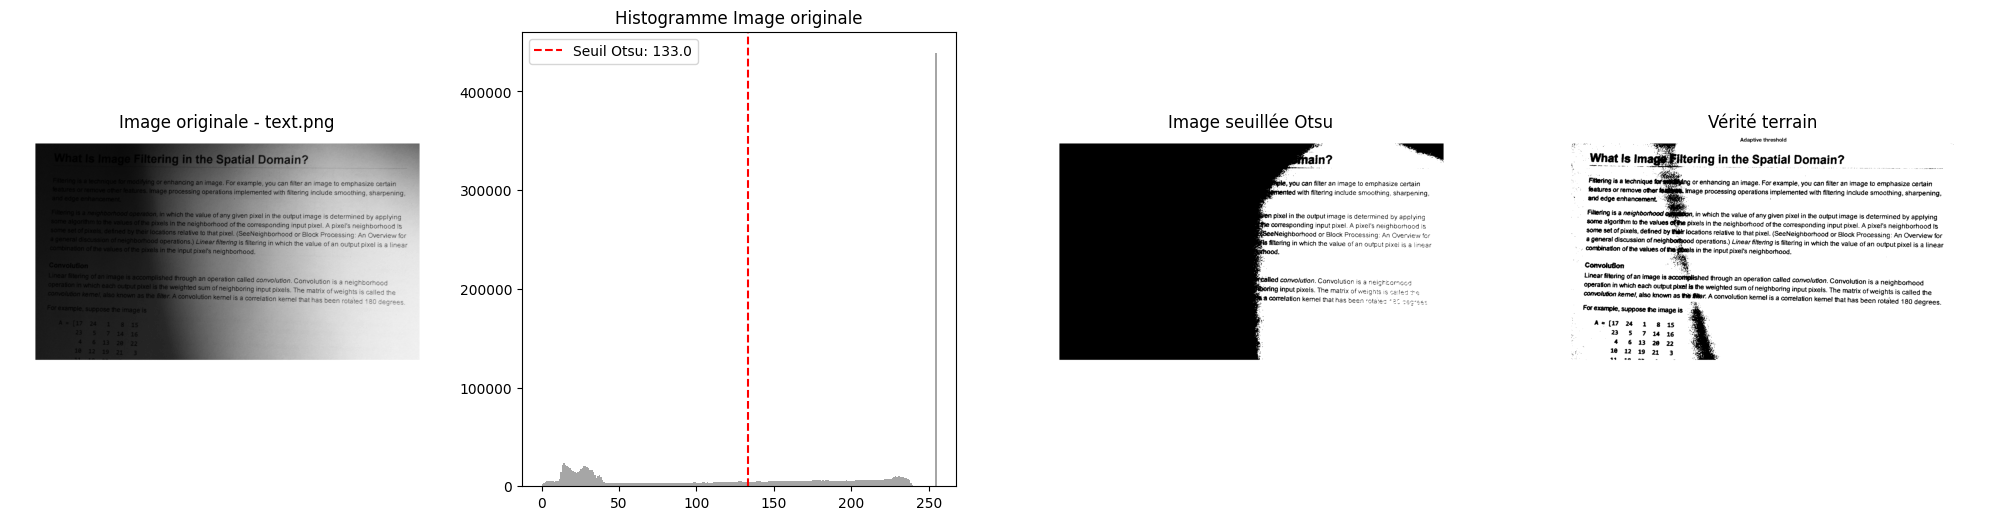

Métriques pour text.png:
  Coefficient de Dice : 0.7541
  Indice de Jaccard (IoU) : 0.6052
  Sensibilité : 0.6096
  Spécificité : 0.9315



In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

# Dossiers des images et des masques de vérité terrain
image_folder = '/content/treshold/Treshold'
ground_truth_folder = '/content/treshold/tresholdTrue'

# Lister et trier les fichiers d'image et de masques
image_files = sorted([f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
ground_truth_files = sorted([f for f in os.listdir(ground_truth_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Vérifier la correspondance entre les deux listes
if len(image_files) != len(ground_truth_files):
    print("Erreur : Les dossiers contiennent un nombre différent de fichiers.")
    exit()

# Fonction pour calculer les métriques
def calculate_metrics(predicted, ground_truth):
    """Calculer le Dice coefficient, Jaccard index, sensibilité, et spécificité."""
    intersection = np.sum(predicted & ground_truth)
    union = np.sum(predicted | ground_truth)

    dice_coefficient = (2 * intersection) / (np.sum(predicted) + np.sum(ground_truth)) if (np.sum(predicted) + np.sum(ground_truth)) > 0 else 0
    jaccard_index = intersection / union if union > 0 else 0
    sensitivity = intersection / np.sum(ground_truth) if np.sum(ground_truth) > 0 else 0
    specificity = np.sum((predicted == 0) & (ground_truth == 0)) / np.sum(ground_truth == 0) if np.sum(ground_truth == 0) > 0 else 0

    return dice_coefficient, jaccard_index, sensitivity, specificity

# Initialiser une liste pour stocker les métriques
metrics = []

# Traiter chaque paire image/masque
for image_file, ground_truth_file in zip(image_files, ground_truth_files):
    # Chemins des fichiers image et masque
    image_path = os.path.join(image_folder, image_file)
    ground_truth_path = os.path.join(ground_truth_folder, ground_truth_file)

    # Charger l'image et le masque de vérité terrain
    image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)

    # Vérifier que les fichiers ont été chargés correctement
    if image_gray is None or ground_truth is None:
        print(f"Erreur lors du chargement de {image_file} ou {ground_truth_file}.")
        continue

    # Appliquer le seuillage Otsu
    _, otsu_thresholded_image = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Convertir les images en format binaire
    ground_truth_binary = (ground_truth > 127).astype(np.uint8)  # Seuil à 127 pour binariser
    predicted_binary = (otsu_thresholded_image > 0).astype(np.uint8)

    # Calculer les métriques
    dice, jaccard, sensitivity, specificity = calculate_metrics(predicted_binary, ground_truth_binary)

    # Stocker les métriques
    metrics.append({
        'image': image_file,
        'dice_coefficient': dice,
        'jaccard_index': jaccard,
        'sensitivity': sensitivity,
        'specificity': specificity
    })

    # Visualiser les résultats
    plt.figure(figsize=(20, 10))

    # Image originale en niveaux de gris
    plt.subplot(2, 4, 1)
    plt.imshow(image_gray, cmap='gray')
    plt.title(f"Image originale - {image_file}")
    plt.axis('off')

    # Histogramme de l'image originale
    plt.subplot(2, 4, 2)
    plt.hist(image_gray.ravel(), bins=256, range=(0, 255), color='gray', alpha=0.7)

    # Ajouter un marqueur pour le seuil Otsu sur l'histogramme
    threshold_value = _  # Valeur du seuil calculée par Otsu
    plt.axvline(x=threshold_value, color='red', linestyle='--', label=f"Seuil Otsu: {threshold_value}")

    plt.title("Histogramme Image originale")
    plt.legend()

    # Image après seuillage Otsu
    plt.subplot(2, 4, 3)
    plt.imshow(otsu_thresholded_image, cmap='gray')
    plt.title("Image seuillée Otsu")
    plt.axis('off')

    # Masque de vérité terrain
    plt.subplot(2, 4, 4)
    plt.imshow(ground_truth_binary, cmap='gray')
    plt.title("Vérité terrain")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Afficher les métriques pour toutes les images
for metric in metrics:
    print(f"Métriques pour {metric['image']}:")
    print(f"  Coefficient de Dice : {metric['dice_coefficient']:.4f}")
    print(f"  Indice de Jaccard (IoU) : {metric['jaccard_index']:.4f}")
    print(f"  Sensibilité : {metric['sensitivity']:.4f}")
    print(f"  Spécificité : {metric['specificity']:.4f}\n")


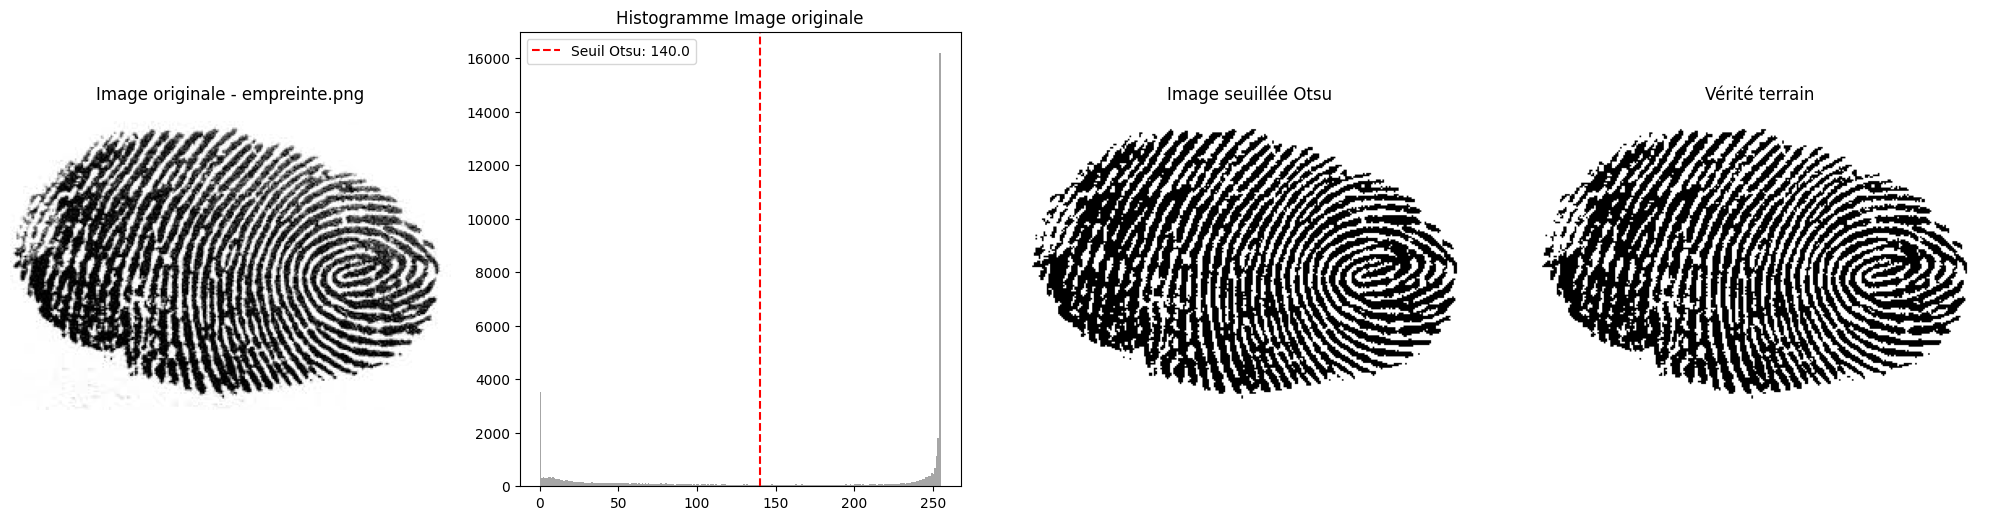

Métriques pour empreinte.png:
  Coefficient de Dice : 0.9874
  Indice de Jaccard (IoU) : 0.9752
  Sensibilité : 0.9752
  Spécificité : 1.0000



In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

# Dossiers des images et des masques de vérité terrain
image_folder = '/content/treshold/otsu'
ground_truth_folder = '/content/treshold/otsu'

# Lister et trier les fichiers d'image et de masques
image_files = sorted([f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
ground_truth_files = sorted([f for f in os.listdir(ground_truth_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Vérifier la correspondance entre les deux listes
if len(image_files) != len(ground_truth_files):
    print("Erreur : Les dossiers contiennent un nombre différent de fichiers.")
    exit()

# Fonction pour calculer les métriques
def calculate_metrics(predicted, ground_truth):
    """Calculer le Dice coefficient, Jaccard index, sensibilité, et spécificité."""
    intersection = np.sum(predicted & ground_truth)
    union = np.sum(predicted | ground_truth)

    dice_coefficient = (2 * intersection) / (np.sum(predicted) + np.sum(ground_truth)) if (np.sum(predicted) + np.sum(ground_truth)) > 0 else 0
    jaccard_index = intersection / union if union > 0 else 0
    sensitivity = intersection / np.sum(ground_truth) if np.sum(ground_truth) > 0 else 0
    specificity = np.sum((predicted == 0) & (ground_truth == 0)) / np.sum(ground_truth == 0) if np.sum(ground_truth == 0) > 0 else 0

    return dice_coefficient, jaccard_index, sensitivity, specificity

# Initialiser une liste pour stocker les métriques
metrics = []

# Traiter chaque paire image/masque
for image_file, ground_truth_file in zip(image_files, ground_truth_files):
    # Chemins des fichiers image et masque
    image_path = os.path.join(image_folder, image_file)
    ground_truth_path = os.path.join(ground_truth_folder, ground_truth_file)

    # Charger l'image et le masque de vérité terrain
    image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)

    # Vérifier que les fichiers ont été chargés correctement
    if image_gray is None or ground_truth is None:
        print(f"Erreur lors du chargement de {image_file} ou {ground_truth_file}.")
        continue

    # Appliquer le seuillage Otsu
    _, otsu_thresholded_image = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Convertir les images en format binaire
    ground_truth_binary = (ground_truth > 127).astype(np.uint8)  # Seuil à 127 pour binariser
    predicted_binary = (otsu_thresholded_image > 0).astype(np.uint8)

    # Calculer les métriques
    dice, jaccard, sensitivity, specificity = calculate_metrics(predicted_binary, ground_truth_binary)

    # Stocker les métriques
    metrics.append({
        'image': image_file,
        'dice_coefficient': dice,
        'jaccard_index': jaccard,
        'sensitivity': sensitivity,
        'specificity': specificity
    })

    # Visualiser les résultats
    plt.figure(figsize=(20, 10))

    # Image originale en niveaux de gris
    plt.subplot(2, 4, 1)
    plt.imshow(image_gray, cmap='gray')
    plt.title(f"Image originale - {image_file}")
    plt.axis('off')

    # Histogramme de l'image originale
    plt.subplot(2, 4, 2)
    plt.hist(image_gray.ravel(), bins=256, range=(0, 255), color='gray', alpha=0.7)

    # Ajouter un marqueur pour le seuil Otsu sur l'histogramme
    threshold_value = _  # Valeur du seuil calculée par Otsu
    plt.axvline(x=threshold_value, color='red', linestyle='--', label=f"Seuil Otsu: {threshold_value}")

    plt.title("Histogramme Image originale")
    plt.legend()

    # Image après seuillage Otsu
    plt.subplot(2, 4, 3)
    plt.imshow(otsu_thresholded_image, cmap='gray')
    plt.title("Image seuillée Otsu")
    plt.axis('off')

    # Masque de vérité terrain
    plt.subplot(2, 4, 4)
    plt.imshow(ground_truth_binary, cmap='gray')
    plt.title("Vérité terrain")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Afficher les métriques pour toutes les images
for metric in metrics:
    print(f"Métriques pour {metric['image']}:")
    print(f"  Coefficient de Dice : {metric['dice_coefficient']:.4f}")
    print(f"  Indice de Jaccard (IoU) : {metric['jaccard_index']:.4f}")
    print(f"  Sensibilité : {metric['sensitivity']:.4f}")
    print(f"  Spécificité : {metric['specificity']:.4f}\n")


# Segmentation par contours actifs (Snakes)

La segmentation par contours actifs, ou "Snakes", est une technique qui utilise une courbe dynamique pour épouser les contours des objets dans une image. Le contour actif est modifié pour minimiser une énergie, prenant en compte à la fois les propriétés de l'image et la forme du contour, et converge vers les bords de l'objet.
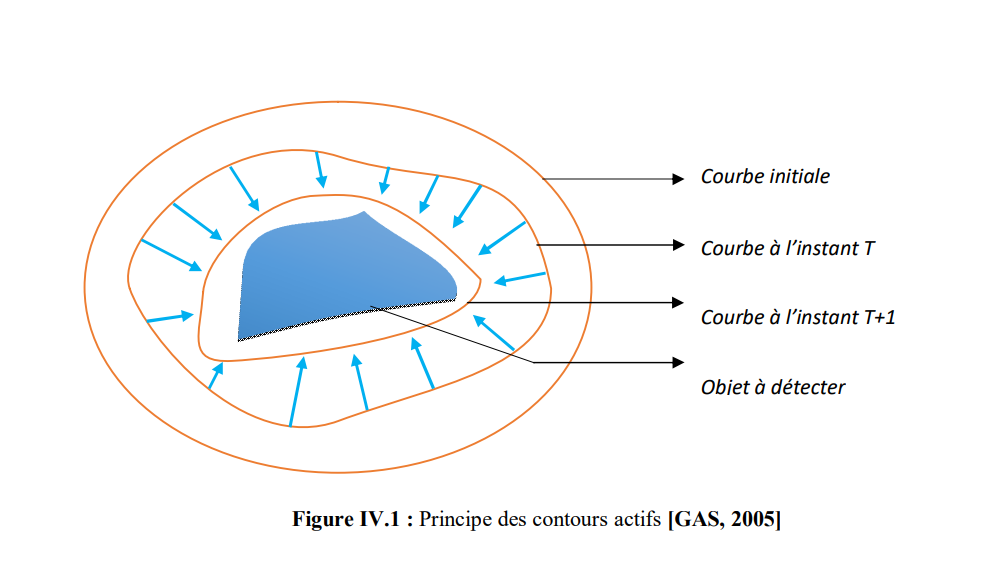

Le principe de cette méthode est de déplacer les points pour les rapprochés des zones de fort
gradient tout en conservant les caractéristiques initiales comme la courbure, changement de
forme du contour ou d’autre contraintes liées au positionnement des points.La méthode de contours actifs est une méthode semi-interactive qui consiste à
positionner dans l’image, plus précisément au voisinage de la forme à détecter, un contour
initial qui subira une déformation sous l’effet de plusieurs forces telle que :

 Une énergie interne E interne permettant de régulariser le contour

 Une énergie potentielle E image reliée à l’image

 Une énergie externe E externe reliée aux contraintes particulières que l’on peut ajouter.

Ces énergies vont permettre au contour actif d’évoluer pour prospecter la position d’énergie
minimale qui sera ainsi un arrangement entre les diverses contraintes du problème [ABR,
2009].

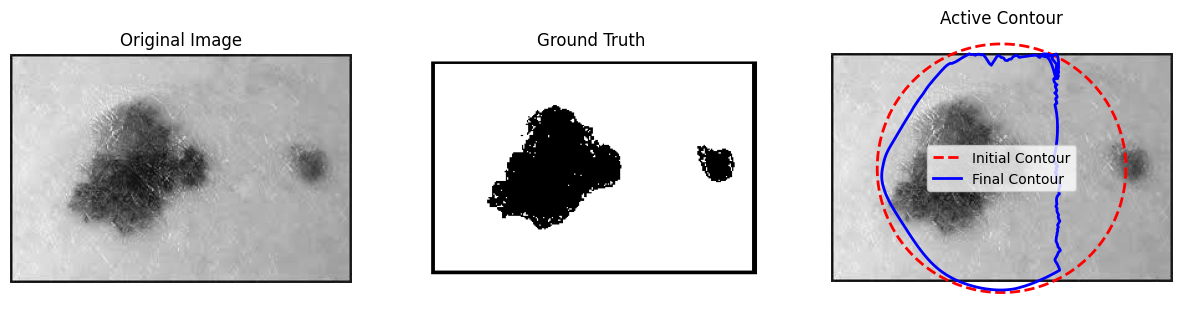

Metrics for skin.png:
  Dice Coefficient: 0.0179
  Jaccard Index (IoU): 0.0091
  Sensitivity: 0.0091
  Specificity: 0.1805



In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from skimage.segmentation import active_contour

# Paths to images and ground truth folders
image_folder = '/content/Snakes/snakes1'
ground_truth_folder = '/content/Snakes/snakesTrue'

# Sort and match image and ground truth files
image_files = sorted([f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
ground_truth_files = sorted([f for f in os.listdir(ground_truth_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

if len(image_files) != len(ground_truth_files):
    print("Error: Mismatch between number of images and ground truth masks.")
    exit()

# Metric computation function
def calculate_metrics(predicted, ground_truth):
    predicted = predicted.astype(bool)
    ground_truth = ground_truth.astype(bool)

    intersection = np.sum(predicted & ground_truth)
    dice_coefficient = (2 * intersection) / (np.sum(predicted) + np.sum(ground_truth) + 1e-6)
    jaccard_index = intersection / (np.sum(predicted | ground_truth) + 1e-6)
    sensitivity = intersection / (np.sum(ground_truth) + 1e-6)
    specificity = np.sum(~predicted & ~ground_truth) / (np.sum(~predicted) + 1e-6)

    return dice_coefficient, jaccard_index, sensitivity, specificity

# Process each image and ground truth pair
metrics = []
for image_file, ground_truth_file in zip(image_files, ground_truth_files):
    # Load the image and ground truth
    image_path = os.path.join(image_folder, image_file)
    ground_truth_path = os.path.join(ground_truth_folder, ground_truth_file)

    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)

    # Resize ground truth to match the image dimensions
    ground_truth_resized = cv2.resize(ground_truth, (gray_image.shape[1], gray_image.shape[0]), interpolation=cv2.INTER_NEAREST)
    ground_truth_binary = (ground_truth_resized > 127).astype(np.uint8)

    # Apply Gaussian smoothing
    smoothed_image = gaussian(gray_image, sigma=1)

    # Define the initial contour (circle at the center of the image)
    s = np.linspace(0, 2 * np.pi, 400)
    x = gray_image.shape[1] // 2 + 100 * np.cos(s)
    y = gray_image.shape[0] // 2 + 100 * np.sin(s)
    initial_contour = np.array([x, y]).T

    # Apply Active Contour (Snakes)
    snake = active_contour(smoothed_image, initial_contour, alpha=0.015, beta=10, gamma=0.001)

    # Create a binary mask from the final contour
    binary_mask = np.zeros(gray_image.shape, dtype=np.uint8)

    # Ensure indices are within bounds
    rr, cc = np.round(snake[:, 1]).astype(int), np.round(snake[:, 0]).astype(int)
    rr = np.clip(rr, 0, gray_image.shape[0] - 1)  # Clamp to image height
    cc = np.clip(cc, 0, gray_image.shape[1] - 1)  # Clamp to image width
    binary_mask[rr, cc] = 1

    # Calculate metrics
    dice_coefficient, jaccard_index, sensitivity, specificity = calculate_metrics(binary_mask, ground_truth_binary)

    # Store metrics
    metrics.append({
        'image': image_file,
        'dice': dice_coefficient,
        'jaccard': jaccard_index,
        'sensitivity': sensitivity,
        'specificity': specificity
    })

    # Display the results for each image
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(gray_image, cmap='gray')
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(ground_truth_binary, cmap='gray')
    ax[1].set_title("Ground Truth")
    ax[1].axis('off')

    ax[2].imshow(gray_image, cmap='gray')
    ax[2].plot(initial_contour[:, 0], initial_contour[:, 1], '--r', lw=2, label='Initial Contour')
    ax[2].plot(snake[:, 0], snake[:, 1], '-b', lw=2, label='Final Contour')
    ax[2].legend()
    ax[2].set_title("Active Contour")
    ax[2].axis('off')
    plt.show()

# Print metrics for all images
for metric in metrics:
    print(f"Metrics for {metric['image']}:")
    print(f"  Dice Coefficient: {metric['dice']:.4f}")
    print(f"  Jaccard Index (IoU): {metric['jaccard']:.4f}")
    print(f"  Sensitivity: {metric['sensitivity']:.4f}")
    print(f"  Specificity: {metric['specificity']:.4f}\n")


OpenCV ne possède pas de méthode directe pour les contours actifs (Snakes), mais on peut utiliser cv2.GaussianBlur et cv2.findContours pour préparer l'image, puis utiliser skimage.segmentation.active_contour de scikit-image pour appliquer cette technique.

# k means segmentation

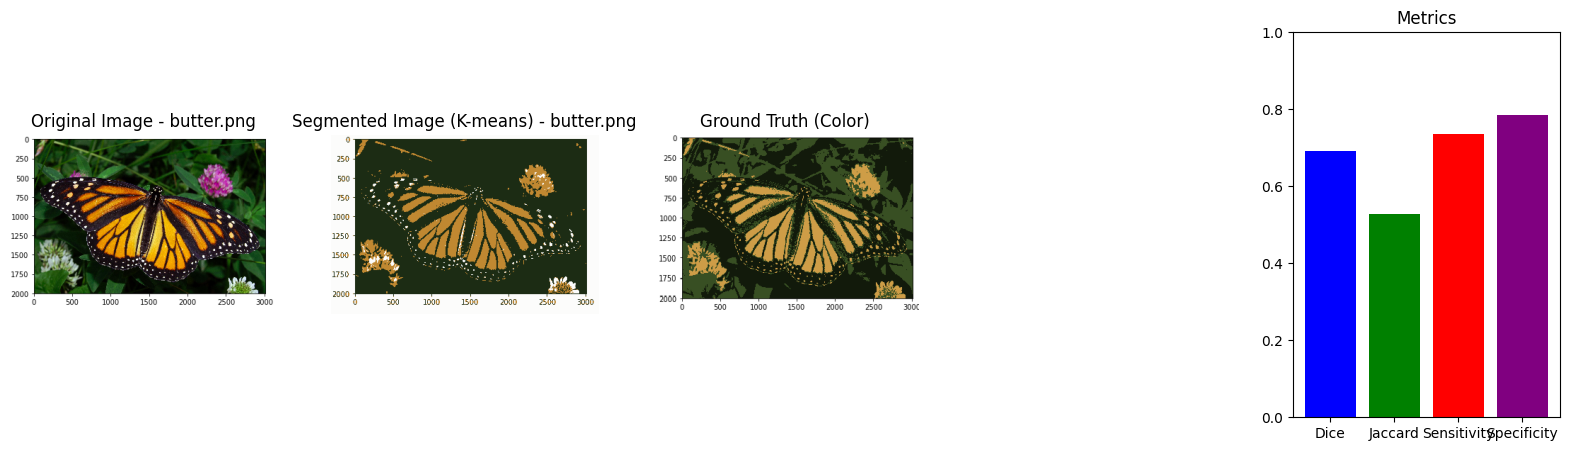

Metrics for butter.png:
  Dice coefficient: 0.6917
  Jaccard index: 0.5287
  Sensitivity: 0.7363
  Specificity: 0.7861



In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Path to the folder containing images and ground truth
image_folder = '/content/butterfly/butterT'
ground_truth_folder = '/content/butterfly/butter1'  # Update this path accordingly

# Number of clusters (k) for segmentation
k = 3  # Adjust this number for more or fewer segments

# List image files in the folder and limit to three
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))][:3]
ground_truth_files = [f for f in os.listdir(ground_truth_folder) if f.endswith(('.png', '.jpg', '.jpeg'))][:3]

# Function to calculate the metrics: Dice coefficient, Jaccard index, sensitivity, specificity
def calculate_metrics(predicted, ground_truth):
    """Calculate Dice coefficient, Jaccard index, sensitivity, and specificity."""
    intersection = np.sum(predicted & ground_truth)
    union = np.sum(predicted | ground_truth)

    dice_coefficient = (2 * intersection) / (np.sum(predicted) + np.sum(ground_truth)) if (np.sum(predicted) + np.sum(ground_truth)) > 0 else 0
    jaccard_index = intersection / union if union > 0 else 0
    sensitivity = intersection / np.sum(ground_truth) if np.sum(ground_truth) > 0 else 0
    specificity = np.sum((predicted == 0) & (ground_truth == 0)) / np.sum(ground_truth == 0) if np.sum(ground_truth == 0) > 0 else 0

    return dice_coefficient, jaccard_index, sensitivity, specificity

# Process each image
for image_file, ground_truth_file in zip(image_files, ground_truth_files):
    # Load the image and ground truth in color
    image_path = os.path.join(image_folder, image_file)
    ground_truth_path = os.path.join(ground_truth_folder, ground_truth_file)

    image = cv2.imread(image_path)
    ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_COLOR)

    # Check that the image was loaded correctly
    if image is None or ground_truth is None:
        print(f"Error loading image {image_file} or ground truth {ground_truth_file}")
        continue

    # Resize ground truth to match image size
    ground_truth_resized = cv2.resize(ground_truth, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Prepare data for K-means (each pixel is a row of color)
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Apply K-means clustering
    compactness, labels, centers = cv2.kmeans(
        pixel_values, k, None,
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),
        5, cv2.KMEANS_RANDOM_CENTERS
    )

    # Replace each pixel by the color of its cluster's center
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)

    # Convert the segmented image to grayscale for comparison
    segmented_gray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)
    segmented_binary = (segmented_gray > 127).astype(np.uint8)  # Binary image for comparison

    # Convert ground truth to grayscale for metrics calculation
    ground_truth_gray = cv2.cvtColor(ground_truth_resized, cv2.COLOR_BGR2GRAY)
    ground_truth_binary = (ground_truth_gray > 127).astype(np.uint8)  # Binarize the resized ground truth

    # Calculate metrics
    dice, jaccard, sensitivity, specificity = calculate_metrics(segmented_binary, ground_truth_binary)

    # Visualize the results
    plt.figure(figsize=(20, 5))

    # Display the original image
    plt.subplot(1, 5, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Original Image - {image_file}")
    plt.axis('off')

    # Display the segmented image
    plt.subplot(1, 5, 2)
    plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Segmented Image (K-means) - {image_file}")
    plt.axis('off')

    # Display the ground truth image in color
    plt.subplot(1, 5, 3)
    plt.imshow(cv2.cvtColor(ground_truth_resized, cv2.COLOR_BGR2RGB))
    plt.title("Ground Truth (Color)")
    plt.axis('off')



    # Plot metrics
    plt.subplot(1, 5, 5)
    plt.bar(['Dice', 'Jaccard', 'Sensitivity', 'Specificity'],
            [dice, jaccard, sensitivity, specificity],
            color=['blue', 'green', 'red', 'purple'])
    plt.title("Metrics")
    plt.ylim(0, 1)
    plt.show()

    # Print metrics
    print(f"Metrics for {image_file}:")
    print(f"  Dice coefficient: {dice:.4f}")
    print(f"  Jaccard index: {jaccard:.4f}")
    print(f"  Sensitivity: {sensitivity:.4f}")
    print(f"  Specificity: {specificity:.4f}\n")


# Watershed Algorithm

In [ ]:
import cv2
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt


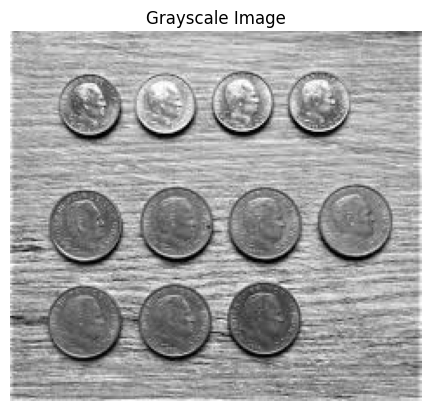

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/centimes.png'
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print("Error loading image. Please check the file path.")
else:
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Display the grayscale image
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis('off')  # Hide axis
    plt.show()


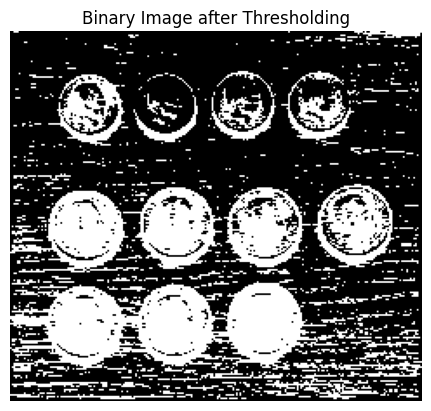

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/centimes.png'
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print("Error loading image. Please check the file path.")
else:
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold Processing
    ret, bin_img = cv2.threshold(gray, 0, 255,
                                  cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Display the binary image
    plt.imshow(bin_img, cmap='gray')  # Use 'gray' colormap for binary images
    plt.title("Binary Image after Thresholding")
    plt.axis('off')  # Hide axis
    plt.show()


Noise Removal

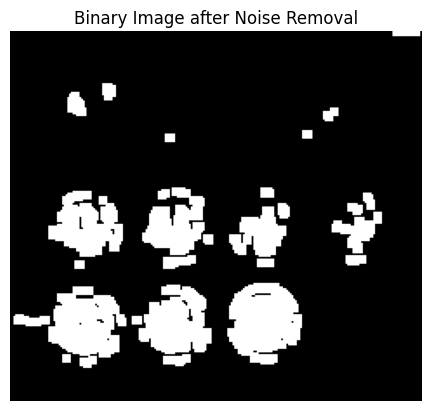

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/centimes.png'
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print("Error loading image. Please check the file path.")
else:
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold Processing
    ret, bin_img = cv2.threshold(gray, 0, 255,
                                  cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise Removal using Morphological Operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=2)

    # Display the binary image after noise removal
    plt.imshow(bin_img, cmap='gray')  # Use 'gray' colormap for binary images
    plt.title("Binary Image after Noise Removal")
    plt.axis('off')  # Hide axis
    plt.show()


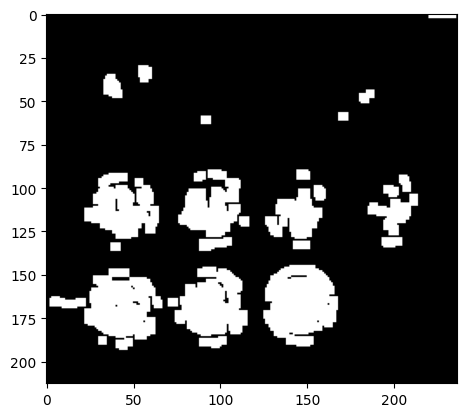

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/centimes.png'
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print("Error loading image. Please check the file path.")
else:
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold Processing
    ret, bin_img = cv2.threshold(gray, 0, 255,
                                  cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise Removal using Morphological Operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=2)

    # Display the binary image after noise removal
    plt.imshow(bin_img, cmap='gray')  # Use 'gray' colormap for binary images



Detecting the black background and foreground of the image

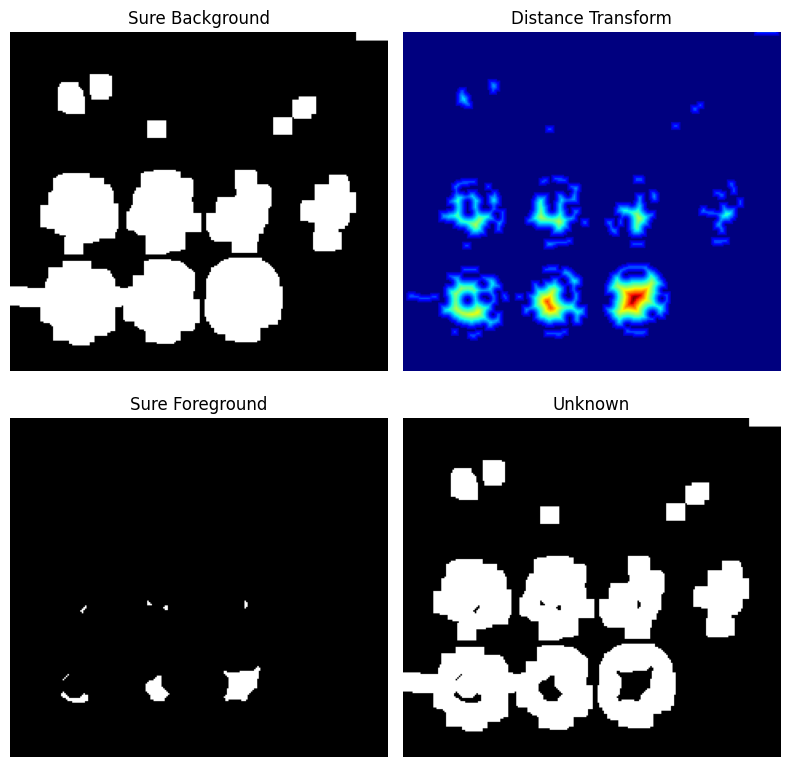

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/centimes.png'
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print("Error loading image. Please check the file path.")
else:
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold Processing
    ret, bin_img = cv2.threshold(gray, 0, 255,
                                  cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise Removal using Morphological Operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=2)

    # Create subplots with 2 rows and 2 columns
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

    # Sure background area
    sure_bg = cv2.dilate(bin_img, kernel, iterations=3)
    axes[0, 0].imshow(sure_bg, cmap='gray')
    axes[0, 0].set_title('Sure Background')
    axes[0, 0].axis('off')  # Hide axis

    # Distance transform
    dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
    axes[0, 1].imshow(dist, cmap='jet')  # Use 'jet' colormap for better visualization
    axes[0, 1].set_title('Distance Transform')
    axes[0, 1].axis('off')  # Hide axis

    # Foreground area
    ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY)
    sure_fg = sure_fg.astype(np.uint8)
    axes[1, 0].imshow(sure_fg, cmap='gray')
    axes[1, 0].set_title('Sure Foreground')
    axes[1, 0].axis('off')  # Hide axis

    # Unknown area
    unknown = cv2.subtract(sure_bg, sure_fg)
    axes[1, 1].imshow(unknown, cmap='gray')
    axes[1, 1].set_title('Unknown')
    axes[1, 1].axis('off')  # Hide axis

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


Creating marker image

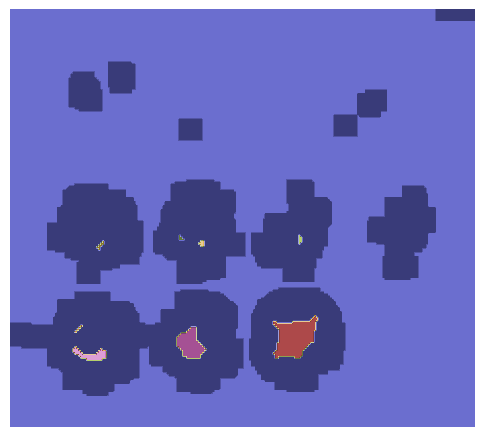

In [ ]:
# Marker labelling
# sure foreground
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that background is not 0, but 1
markers += 1
# mark the region of unknown with zero
markers[unknown == 255] = 0

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()


Applying Watershed Algorithm to Markers

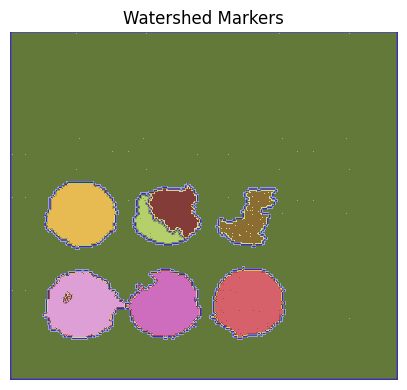

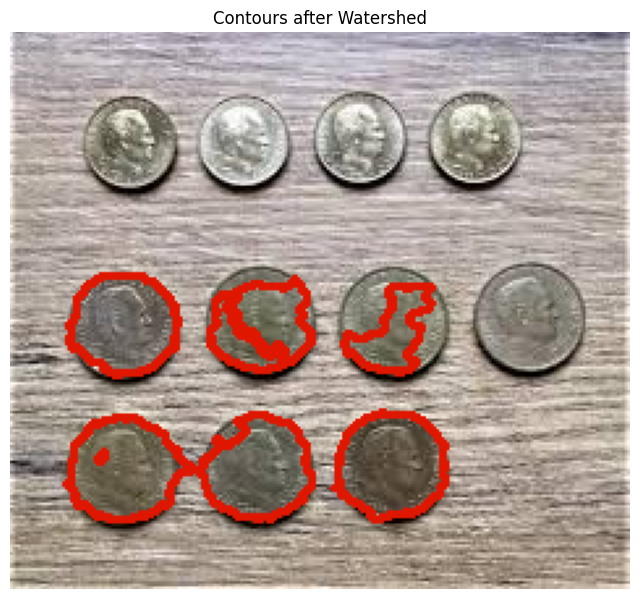

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/centimes.png'
img = cv2.imread(image_path)

# Check if the image was loaded successfully
if img is None:
    print("Error loading image. Please check the file path.")
else:
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold Processing
    ret, bin_img = cv2.threshold(gray, 0, 255,
                                  cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise Removal using Morphological Operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=2)

    # Create sure background area
    sure_bg = cv2.dilate(bin_img, kernel, iterations=3)

    # Distance transform
    dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY)
    sure_fg = sure_fg.astype(np.uint8)

    # Unknown area
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Markers for watershed
    markers = cv2.connectedComponents(sure_fg)[1]  # Get markers
    markers = markers + 1  # Increment all markers by 1
    markers[unknown == 255] = 0  # Mark unknown regions as 0

    # Apply the Watershed algorithm
    markers = cv2.watershed(img, markers)

    # Display the markers with colormap
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(markers, cmap="tab20b")
    ax.axis('off')
    plt.title("Watershed Markers")
    plt.show()

    # Extract contours
    labels = np.unique(markers)
    coins = []

    for label in labels[2:]:  # Skip the first two labels (background and unknown)
        # Create a binary image for the current label
        target = np.where(markers == label, 255, 0).astype(np.uint8)

        # Perform contour extraction
        contours, hierarchy = cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:  # Check if any contours were found
            coins.append(contours[0])

    # Draw the contours on the original image
    img_contours = img.copy()  # Create a copy of the original image
    img_contours = cv2.drawContours(img_contours, coins, -1, color=(0, 23, 223), thickness=2)

    # Display the result with drawn contours
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title("Contours after Watershed")
    plt.axis('off')
    plt.show()


In [ ]:
from sklearn.metrics import jaccard_score


# Function to calculate the metrics
def calculate_metrics(ground_truth, predicted_mask):
    # Flatten the arrays for metric calculations
    ground_truth = ground_truth.flatten()
    predicted_mask = predicted_mask.flatten()

    # Calculate TP, FP, FN, TN
    TP = np.sum((predicted_mask == 255) & (ground_truth == 255))
    FP = np.sum((predicted_mask == 255) & (ground_truth == 0))
    FN = np.sum((predicted_mask == 0) & (ground_truth == 255))
    TN = np.sum((predicted_mask == 0) & (ground_truth == 0))

    # Dice Coefficient
    dice = 2 * TP / (2 * TP + FP + FN) if (TP + FP + FN) > 0 else 0.0

    # Jaccard Index (IoU)
    jaccard = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0.0

    # Sensitivity (Recall)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0

    # Specificity
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0

    return {
        "Dice": dice,
        "Jaccard": jaccard,
        "Sensitivity": sensitivity,
        "Specificity": specificity
    }

# Assuming ground_truth_mask is the binary mask of ground truth where coins are marked in white (255)
# Replace with the actual path to the ground truth mask image
ground_truth_path = '/content/centimes.png'
ground_truth_mask = cv2.imread(ground_truth_path, 0)

# Check if ground truth was loaded
if ground_truth_mask is None:
    print("Error loading ground truth image. Please check the file path.")
else:
    # Convert watershed markers to binary mask
    watershed_mask = np.where(markers > 1, 255, 0).astype(np.uint8)  # Non-background regions set to 255

    # Calculate metrics
    metrics = calculate_metrics(ground_truth_mask, watershed_mask)

    # Display the metrics
    print("Metrics for Watershed Segmentation:")
    print(f"  Dice Coefficient: {metrics['Dice']:.4f}")
    print(f"  Jaccard Index (IoU): {metrics['Jaccard']:.4f}")
    print(f"  Sensitivity: {metrics['Sensitivity']:.4f}")
    print(f"  Specificity: {metrics['Specificity']:.4f}")


Metrics for Watershed Segmentation:
  Dice Coefficient: 0.0000
  Jaccard Index (IoU): 0.0000
  Sensitivity: 0.0000
  Specificity: 0.9840


Dice Coefficient (0.0000): The Dice coefficient, which measures the similarity between the segmented result and the ground truth, is zero. This means there is no overlap between the segmented regions and the actual regions in the ground truth mask.

Jaccard Index (IoU) (0.0000): Like the Dice coefficient, the Jaccard index is also zero, which reinforces that there is no intersection between the detected regions and the true regions. The segmentation failed to match any part of the actual objects.

Sensitivity (0.0000): Sensitivity, or recall, measures how well the model correctly identifies actual positives (objects). A sensitivity of zero implies that the watershed segmentation did not correctly detect any part of the objects in the ground truth.

Specificity (0.9840): Specificity measures how well the model avoided marking background pixels as part of the objects. A high specificity of 0.9840 suggests that the watershed segmentation was largely successful in identifying background pixels correctly, with few false positives.

# Croissance de regions (Region Growing)

Region growing breaks down images into distinct areas. It starts by picking individual pixels (seeds) and then incorporates their neighbors that share similar characteristics, like color or intensity. This process continues until well-defined regions emerge, making it a simple yet effective segmentation technique.

Logic behind region growing algorithm is principle of similarity.

Principle of similarity states that region is coherent if all pixels of that region are homogeneous. Similarity of regions is used as the main segmentation criterion in region growing. (choice of criteria affects segmentation results dramatically!)
Gray level
Color
Texture
Shape
Model etc.
Major steps of region growing algorithm are:

Selection of initial seed
Seed growing criteria
Termination of segmentation process
For example, from one image, select one pixel p1 as an RGB value (91,134,234) and one pixel p2 as an RGB value (231,105,100). Now check whether these two pixels are similar to each other or homogeneous.We will check using Euclidean distance, and distance is represented as d (p1, p2).


Putting each pixel value into a formula and calculating the distance between two pixels. The answer here is approximately 195.951 units. Then, the user must define a homogeneity threshold (T) between pixels. If the distance is less than or equal to the threshold, then pixels are homogeneous; if the distance is greater than the threshold value, then pixels are not homogeneous.


Similarly, do more initial seed points, choose the threshold value wisely, and compute the similarity region from the image.



#Performance:
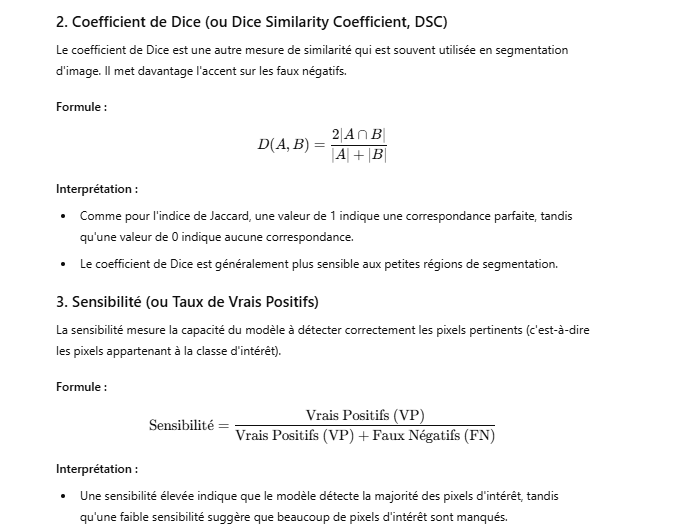
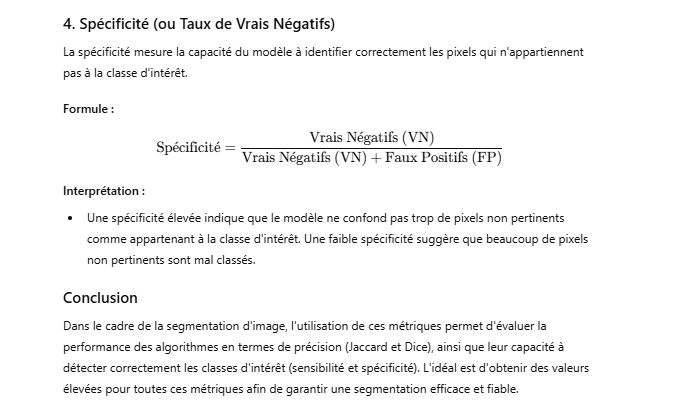

Metrics for Region Growing Segmentation:
  Dice Coefficient: 0.0000
  Jaccard Index (IoU): 0.0000
  Sensitivity: 0.0000
  Specificity: 0.4793


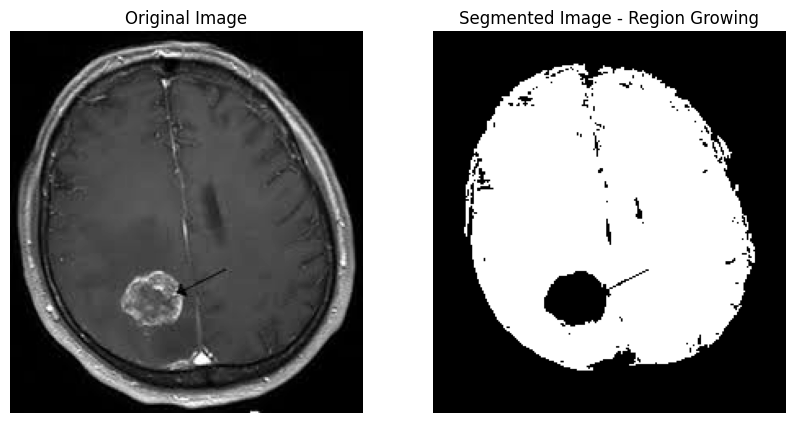

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function for region growing segmentation
def region_growing(image, seed, threshold):
    h, w = image.shape
    segmented_image = np.zeros((h, w), dtype=np.uint8)
    region_mean = image[seed[1], seed[0]]
    region_size = 1
    pixel_list = [seed]

    while pixel_list:
        x, y = pixel_list.pop(0)
        segmented_image[y, x] = 255

        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < w and 0 <= ny < h and segmented_image[ny, nx] == 0:
                if abs(int(image[ny, nx]) - int(region_mean)) < threshold:
                    pixel_list.append((nx, ny))
                    segmented_image[ny, nx] = 255
                    region_mean = (region_mean * region_size + image[ny, nx]) / (region_size + 1)
                    region_size += 1
    return segmented_image

# Metrics calculation function
def calculate_metrics(ground_truth, predicted_mask):
    predicted_mask = predicted_mask.flatten()

    TP = np.sum((predicted_mask == 255) & (ground_truth.flatten() == 255))
    FP = np.sum((predicted_mask == 255) & (ground_truth.flatten() == 0))
    FN = np.sum((predicted_mask == 0) & (ground_truth.flatten() == 255))
    TN = np.sum((predicted_mask == 0) & (ground_truth.flatten() == 0))

    dice = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) != 0 else 0
    jaccard = TP / (TP + FP + FN) if (TP + FP + FN) != 0 else 0
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    return {'Dice': dice, 'Jaccard': jaccard, 'Sensitivity': sensitivity, 'Specificity': specificity}

# Load the image and apply region growing
image_path = 'brain1.png'  # Replace with your image path
image = cv2.imread(image_path, 0)
seed_point = (100, 150)
threshold_value = 30
segmented_result = region_growing(image, seed_point, threshold_value)

# Ground truth mask (replace this with actual mask)
ground_truth = cv2.imread('brain1.png', 0)  # Replace with the path to your ground truth mask
_, ground_truth = cv2.threshold(ground_truth, 127, 255, cv2.THRESH_BINARY)  # Ensure binary mask

# Calculate metrics
metrics = calculate_metrics(ground_truth, segmented_result)
print("Metrics for Region Growing Segmentation:")
print(f"  Dice Coefficient: {metrics['Dice']:.4f}")
print(f"  Jaccard Index (IoU): {metrics['Jaccard']:.4f}")
print(f"  Sensitivity: {metrics['Sensitivity']:.4f}")
print(f"  Specificity: {metrics['Specificity']:.4f}")

# Display the original image and segmented result
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_result, cmap='gray')
plt.title("Segmented Image - Region Growing")
plt.axis('off')

plt.show()


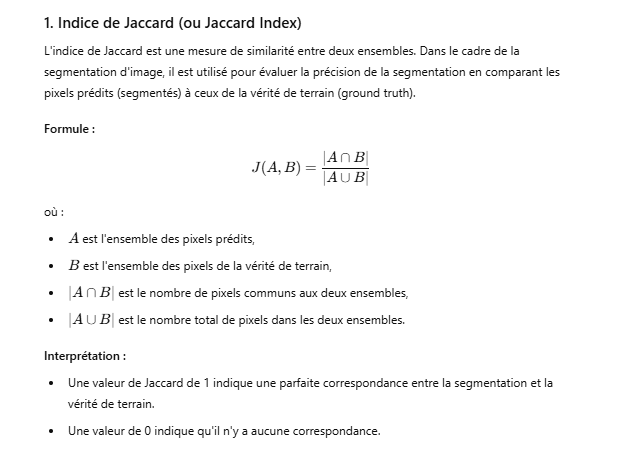

Dice Coefficient: 0.0000 – The Dice Coefficient measures the overlap between the segmented output and the ground truth mask. A score of 0 means that there is no overlap between the two, indicating that the region-growing algorithm did not successfully capture the target region defined in the ground truth mask.

Jaccard Index (IoU): 0.0000 – The Jaccard Index, or Intersection over Union (IoU), also indicates the similarity between the segmented output and ground truth. A score of 0 here reinforces that no meaningful overlap exists, pointing to an unsuccessful segmentation.

Sensitivity (Recall): 0.0000 – Sensitivity measures how well the model identifies true positives, i.e., correctly segmented pixels. A score of 0 means the model didn’t capture any true positive pixels in the target region, failing to identify any part of the region defined in the ground truth.

Specificity: 0.4793 – Specificity measures how well the model identifies true negatives, or pixels that are correctly identified as background (not part of the region). A specificity of 0.4793 means that the model is reasonably successful in identifying background pixels, though this is only moderately above random guessing (0.5).

##Interpretation:

The results show that this segmentation approach, as currently applied, did not capture the region of interest defined in the ground truth. Possible causes could be:

Seed Point or Threshold: The seed point or threshold chosen might not be well-suited for accurately growing the target region.
Inadequate Preprocessing: The image might benefit from preprocessing steps (e.g., contrast enhancement) to better delineate the target region.
Algorithm Limitations: Region growing might not be suitable for this particular image if there isn’t a clear intensity distinction between the target region and the surrounding area.

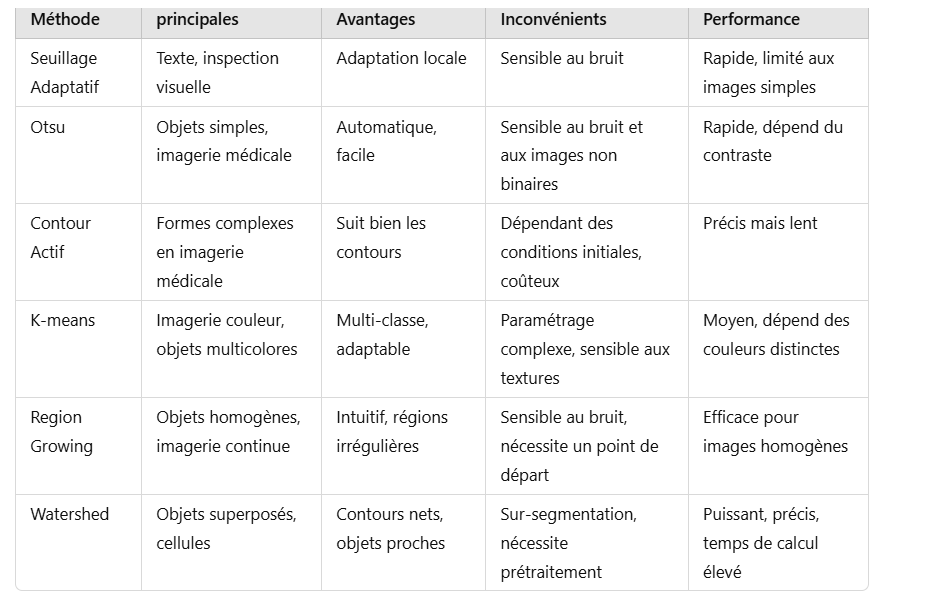